# Trajectory Completion Application for the KLT Paper

This notebook provides the figures for the Trajectory Completion application.

## Load the trajectory data, as usual

In [1]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("../spherical-code-paper/trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

Text(0, 0.5, 'Roadwise coordinate (ft)')

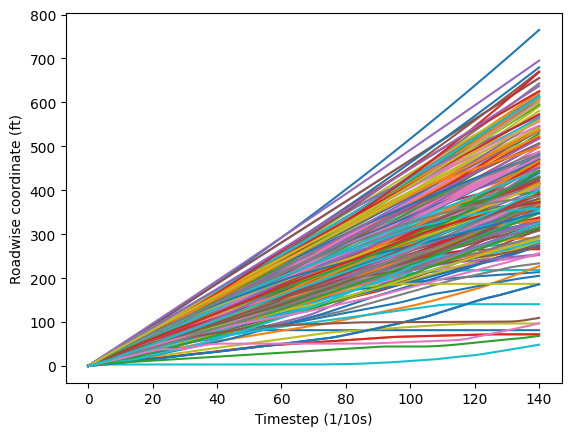

In [2]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])
plt.xlabel('Timestep (1/10s)')
plt.ylabel('Roadwise coordinate (ft)')

# FPCA Decomposition

In [3]:
import skfda
fdgry = skfda.FDataGrid(y_vec, np.arange(y_vec.shape[1]))

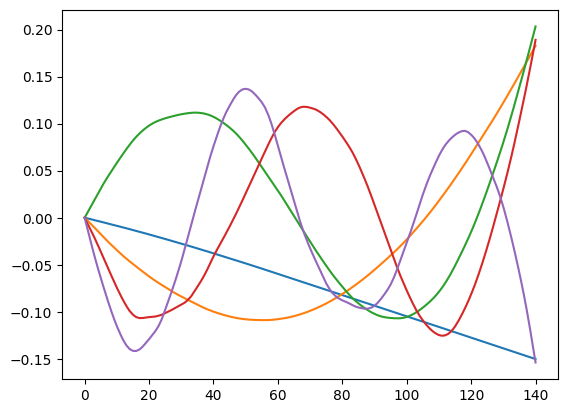

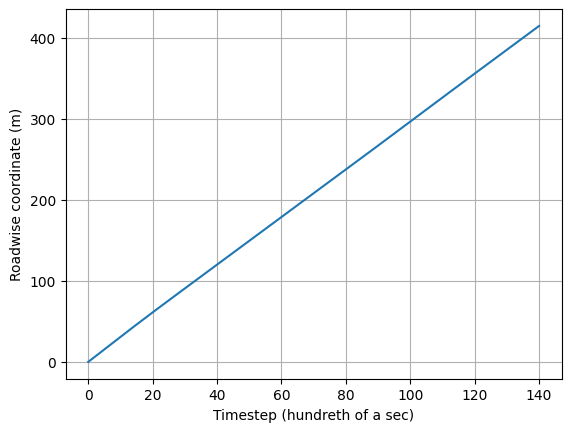

In [4]:
from skfda.preprocessing.dim_reduction.projection import FPCA

fpca_discretized_rw = FPCA(n_components=5)
fpca_discretized_rw.fit(fdgry)
fpca_discretized_rw.components_.plot()
fpca_discretized_rw.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')

In [5]:
# Get the FPCA scores for each trajectory
fpca_scores = fpca_discretized_rw.transform(fdgry)

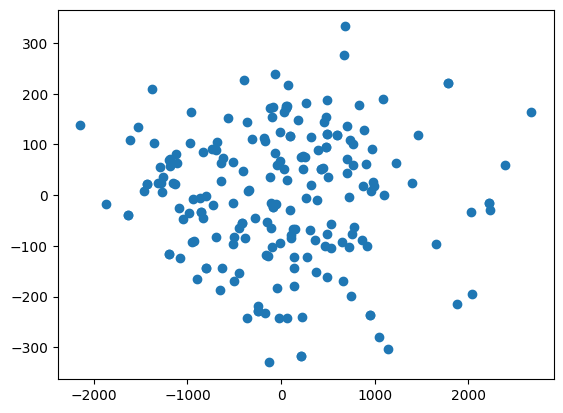

In [6]:
plt.scatter(fpca_scores[:,0], fpca_scores[:,1])

# Fitting of Gaussian distribution

In [27]:
# fit a multivariate gaussian distribution to the scores
from scipy.stats import multivariate_normal
mu = np.mean(fpca_scores, axis=0)
cov = np.cov(fpca_scores.T)

mu2d = np.mean(fpca_scores[:,:2], axis=0)
cov2d = np.cov(fpca_scores[:,:2].T)

# Trajectory Completion

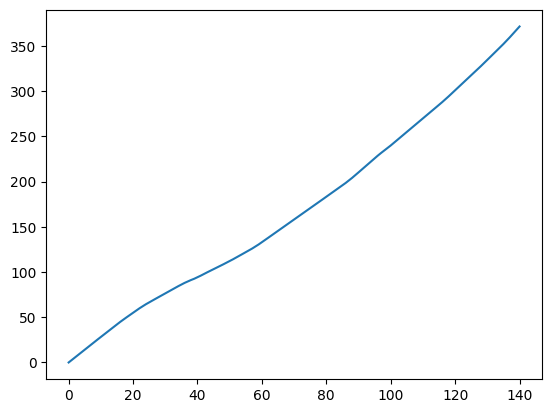

In [8]:
# sample trajectory 
sample_traj = y_vec[1]
plt.plot(sample_traj)

In [9]:
fpca_discretized_rw.mean_.data_matrix.shape

(1, 141, 1)

In [91]:
# Now suppose the observed trajectory is the first 30 timesteps
# Initialization of the estimator
phi = fpca_discretized_rw.components_.data_matrix.copy()
sigma_prime = cov.copy()
mu_prime = np.zeros((5,))

# Hyperparameters
sigma_x = 50 # measurement variance

for i in range(100):
    phi_i = phi[:,i,:].flatten()
    mu_i = fpca_discretized_rw.mean_.data_matrix[:,i,:].flatten()
    sigma_prime = np.linalg.inv(np.linalg.inv(sigma_prime) + 1/sigma_x * np.outer(phi_i, phi_i))
    mu_prime = mu_prime + 1/sigma_x * (sample_traj[i] - mu_i) * phi_i
    mu_post = sigma_prime @ mu_prime
    
print('Best estimate of the trajectory')
print(mu_post)
    

Best estimate of the trajectory
[511.03362325 104.06626504  36.02146926 -25.97341009  -9.21342885]


In [92]:
phi = fpca_discretized_rw.components_.data_matrix.copy()
phi = fpca_discretized_rw.components_.data_matrix.copy().reshape(phi.shape[0], phi.shape[1])
mu_curve = fpca_discretized_rw.mean_.data_matrix.copy().flatten()

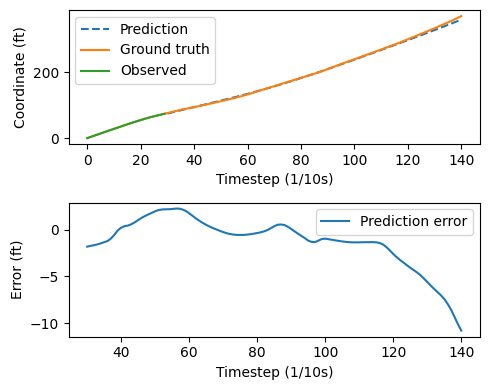

In [119]:
plt.figure(figsize=(5, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(30, sample_traj.shape[0]), (mu_curve + mu_post @ phi)[30:], '--', label='Prediction')
plt.plot(sample_traj, label='Ground truth')
plt.plot(sample_traj[:30], label='Observed')
plt.legend()
plt.xlabel('Timestep (1/10s)')
plt.ylabel('Coordinate (ft)')
plt.subplot(2, 1, 2)
plt.plot(np.arange(30, sample_traj.shape[0]), (mu_curve + mu_post @ phi)[30:] - sample_traj[30:], label='Prediction error')
plt.legend()
plt.xlabel('Timestep (1/10s)')
plt.ylabel('Error (ft)')
plt.tight_layout()
plt.savefig('trajectory_completion.pdf')

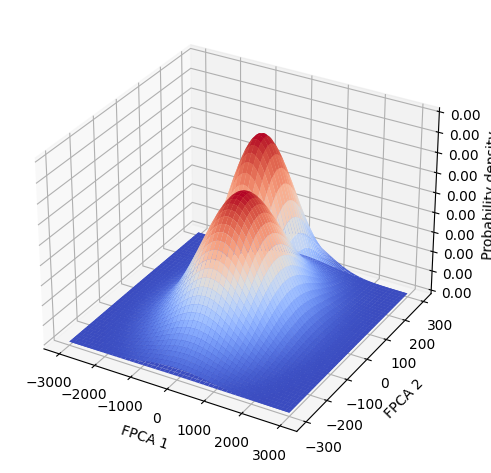

In [113]:
# Plot the prior and posterior distributions

# Plot the scores and the fitted gaussian
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Make data.
X = np.arange(-3000, 3000, 1)
Y = np.arange(-300, 300, 1)
X, Y = np.meshgrid(X, Y) # 60,40
pos = np.empty(X.shape + (2,)) # 60,40,2
pos[:, :, 0] = X; pos[:, :, 1] = Y
# Prior
Z = multivariate_normal.pdf(pos, mean=mu2d, cov=cov2d)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                          linewidth=0, antialiased=True)
# Post
Zp = multivariate_normal.pdf(pos, mean=mu2d + np.random.rand(2) * 1e2, cov=cov2d*0.75)
# Plot the surface.
surfp = ax.plot_surface(X, Y, Zp, cmap=cm.coolwarm,
                            linewidth=0, antialiased=True)
# Customize the z axis.
ax.set_zlim(0, 2e-6)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('FPCA 1')
ax.set_ylabel('FPCA 2')
ax.set_zlabel('Probability density')
# ax.set_title('FPCA scores of trajectories')
plt.tight_layout()

plt.savefig('prior_posterior.pdf')


In [105]:
np.random.rand(5) * 1e2

array([37.79206694, 84.81892549, 68.99726533, 82.22923193, 65.80476208])

In [100]:
sigma_prime[:2,:2]

array([[ 3249.24250073, -2491.49726322],
       [-2491.49726322,  2013.49314927]])

In [69]:
cov2d

array([[7.82832142e+05, 1.45109651e-09],
       [1.45109651e-09, 1.66578577e+04]])